In [1]:
import json
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from pathlib import Path
from collections import defaultdict
from features.utils import build_mapping_to_ids

warnings.filterwarnings('ignore')

# Data

### Get all problems

In [2]:
dataset = pd.read_csv("data/java_2000_dataset_code.csv")

In [3]:
# Drop rows where null values exist in 'focal_class_code' or 'test_class_code'
dataset.dropna(subset=['focal_class_code', 'test_class_code'], inplace=True)

In [4]:
dataset.head()

,repo_id,url,language,fork_count,stargazer_count,focal_class_identifier,focal_class_superclass,focal_class_interfaces,focal_class_fields,focal_class_methods,...,test_case_return,test_case_body,test_case_signature,test_case_full_signature,test_case_class_method_signature,test_case_testcase,test_case_constructor,test_case_invocations,focal_class_code,test_class_code
0,58314354,https://github.com/bytefish/JavaElasticSearchE...,Java,11,0,IgnoreMissingValuesConverter,NaN,implements ITypeConverter<Float>,[{'original_string': 'private List<String> mis...,[{'identifier': 'IgnoreMissingValuesConverter'...,...,void,@Test\n public void returns_null_if_value_i...,void returns_null_if_value_is_missing(),@Test public void returns_null_if_value_is_mis...,IgnoreMissingValuesConverterTest.returns_null_...,True,False,"['assertEquals', 'convert', 'assertEquals', 'c...",// Copyright (c) Philipp Wagner. All rights re...,// Copyright (c) Philipp Wagner. All rights re...
1,58314354,https://github.com/bytefish/JavaElasticSearchE...,Java,11,0,DateUtilities,NaN,NaN,[],"[{'identifier': 'from', 'parameters': '(LocalD...",...,void,@Test\n public void generated_date_has_utc_...,void generated_date_has_utc_offset_when_none_i...,@Test public void generated_date_has_utc_offse...,DateUtilitiesTest.generated_date_has_utc_offse...,True,False,"['of', 'of', 'atTime', 'atOffset', 'from', 'as...",// Copyright (c) Philipp Wagner. All rights re...,// Copyright (c) Philipp Wagner. All rights re...
2,58314354,https://github.com/bytefish/JavaElasticSearchE...,Java,11,0,DateUtilities,NaN,NaN,[],"[{'identifier': 'from', 'parameters': '(LocalD...",...,void,@Test\n public void generated_date_has_give...,void generated_date_has_given_offset_when_offs...,@Test public void generated_date_has_given_off...,DateUtilitiesTest.generated_date_has_given_off...,True,False,"['of', 'of', 'ofHours', 'atTime', 'atOffset', ...",// Copyright (c) Philipp Wagner. All rights re...,// Copyright (c) Philipp Wagner. All rights re...
3,58314354,https://github.com/bytefish/JavaElasticSearchE...,Java,11,0,DateUtilities,NaN,NaN,[],"[{'identifier': 'from', 'parameters': '(LocalD...",...,void,@Test\n public void generated_date_has_give...,void generated_date_has_given_timezone_when_gi...,@Test public void generated_date_has_given_tim...,DateUtilitiesTest.generated_date_has_given_tim...,True,False,"['of', 'of', 'atTime', 'ofHours', 'atOffset', ...",// Copyright (c) Philipp Wagner. All rights re...,// Copyright (c) Philipp Wagner. All rights re...
4,58314354,https://github.com/bytefish/JavaElasticSearchE...,Java,11,0,LocalWeatherDataConverter,NaN,NaN,[],"[{'identifier': 'convert', 'parameters': '(csv...",...,void,@Test\n public void testConvert() throws Ex...,void testConvert(),@Test public void testConvert(),LocalWeatherDataConverterTest.testConvert(),True,False,"['setWban', 'setDate', 'of', 'setTime', 'of', ...",// Copyright (c) Philipp Wagner. All rights re...,// Copyright (c) Philipp Wagner. All rights re...


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1929 entries, 0 to 1999
Data columns (total 40 columns):
repo_id                                1929 non-null int64
url                                    1929 non-null object
language                               1569 non-null object
fork_count                             1929 non-null int64
stargazer_count                        1929 non-null int64
focal_class_identifier                 1929 non-null object
focal_class_superclass                 633 non-null object
focal_class_interfaces                 885 non-null object
focal_class_fields                     1929 non-null object
focal_class_methods                    1929 non-null object
focal_class_file                       1929 non-null object
focal_method_identifier                1929 non-null object
focal_method_parameters                1929 non-null object
focal_method_modifiers                 1841 non-null object
focal_method_return                    1900 non-null objec

In [6]:
dataset.isnull().sum()

repo_id                                   0
url                                       0
language                                360
fork_count                                0
stargazer_count                           0
focal_class_identifier                    0
focal_class_superclass                 1296
focal_class_interfaces                 1044
focal_class_fields                        0
focal_class_methods                       0
focal_class_file                          0
focal_method_identifier                   0
focal_method_parameters                   0
focal_method_modifiers                   88
focal_method_return                      29
focal_method_body                         0
focal_method_signature                    0
focal_method_full_signature               0
focal_method_class_method_signature       0
focal_method_testcase                     0
focal_method_constructor                  0
focal_method_invocations                  0
test_class_identifier           

# Build dataset

In [7]:
from features import *
from sklearn.feature_selection import mutual_info_regression

In [8]:
# codes = dataset['focal_class_code'].values  # Assuming 'code_column' is the name of your column with the code

codes_with_ids = [{'repo_id': row['repo_id'], 'code': row['focal_class_code']} for index, row in dataset.iterrows()]

samples = calculate_features_for_files(codes_with_ids)

### Minor EDA for samples

In [9]:
samplesdf = pd.DataFrame(samples) 

In [10]:
samplesdf.shape

(1914, 14289)

In [11]:
column_name = 'repo_id'
# Pop the column out of the DataFrame
desired_column = samplesdf.pop(column_name)
# Reinsert it at the beginning of the DataFrame
samplesdf.insert(0, column_name, desired_column)

In [12]:
samplesdf.head()

,repo_id,WordUnigramTF_csv,WordUnigramTF_converter,WordUnigramTF_de,WordUnigramTF_bytefish,WordUnigramTF_jtinycsvparser,WordUnigramTF_typeconverter,WordUnigramTF_ITypeConverter,WordUnigramTF_utils,WordUnigramTF_StringUtils,...,WordUnigramTF_getOnlyThreadPoolUtilization,WordUnigramTF_sampleCommandUtilization,WordUnigramTF_sampleThreadPoolUtilization,WordUnigramTF_commandUtilizationPerKey,WordUnigramTF_threadPoolUtilizationPerKey,WordUnigramTF_hystrixUtilization,WordUnigramTF_getCommandUtilizationMap,WordUnigramTF_getThreadPoolUtilizationMap,WordUnigramTF_doThrow,WordUnigramTF_RollingCollapserBatchSizeDistributionStream
0,58314354,0.016393,0.016393,0.016393,0.016393,0.016393,0.016393,0.032787,0.016393,0.032787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58314354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016129,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,58314354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016129,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,58314354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016129,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58314354,0.029703,0.009901,NaN,NaN,NaN,NaN,NaN,0.009901,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# columns_to_check = [
#     "WordUnigramTF",
#     "In(numkeywords/length)",
#     "In(numTernary/length)",
#     "In(numTokens/length)",
#     "In(numComments/length)",
#     "In(numLiterals/length)",
#     "In(numKeywords/length)",
#     "In(numFunctions/length)",
#     "In(numMacros/length)",
#     "nestingDepth",
#     "branchingFactor",
#     "avgParams",
#     "stdDevNumParams",
#     "avgLineLength",
#     "stdDevLineLength",
#     "In(numTabs/length)",
#     "In(numSpaces/length)",
#     "In(numEmptyLines/length)",
#     "whiteSpaceRatio",
#     "newLineBeforeOpenBrace",
#     "tabsLeadLines",
#     "MaxDepthASTNode",
#     "ASTNodeBigramsTF",
#     "ASTNodeTypesTF",
#     "ASTNodeTypesTFIDF",
#     "ASTNodeTypeAvgDep",
#     "cppKeywords",
#     "CodeInASTLeavesTF",
#     "CodeInASTLeavesTFIDF",
#     "CodeInASTLeavesAvgDep"
# ]

# # Function to clean column names
# def clean_column_name(name):
#     return name.replace(" ", "").replace("In", "ln").lower()

# # Clean DataFrame column names
# xdf.columns = [clean_column_name(name) for name in xdf.columns]

# # Check each column
# for col in columns_to_check:
#     cleaned_col = clean_column_name(col)
#     if cleaned_col in xdf.columns:
#         print(f"Column '{col}' exists in the DataFrame.")
#     else:
#         print(f"Column '{col}' does NOT exist in the DataFrame.")

## Build X and Y 

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import numpy as np

In [22]:
y = samplesdf['repo_id']
X = samplesdf.drop(columns=['repo_id'])

In [23]:
X.fillna(0, inplace=True)

### Select the best 1500 features according to mutual information

In [24]:
# Convert to numpy array for mutual information calculation if needed
X_np = X.to_numpy(dtype=np.float32)

# Replace inf/-inf with large finite numbers (if infinities are expected)
X_np = np.where(np.isinf(X_np), np.finfo(np.float32).max, X_np)

In [25]:
# Calculate mutual information
mi = mutual_info_regression(X_np, y, random_state=0)
mi /= np.max(mi)  # Normalize mutual information scores for better comparison

# Select the top 1500 features
mi_indices = np.argsort(mi)[-1500:]  # Get indices of top 1500 features
selected_features = X.columns[mi_indices]  # Get feature names
X = X[selected_features]  # Subset X to keep only selected features

print(f'Number of samples: {X.shape[0]}')
print(f'Number of features: {X.shape[1]}')

Number of samples: 1914
Number of features: 1500


In [26]:
X.head()

,WordUnigramTF_andThreadPoolPropertiesDefaults,WordUnigramTF_DARK,WordUnigramTF_configuredTheme,WordUnigramTF_showSizePanelIcon,WordUnigramTF_MethodSignature,WordUnigramTF_articles,WordUnigramTF_MapStoreFactory,WordUnigramTF_pragmaSynchronous,WordUnigramTF_parent,WordUnigramTF_getGamesLocator,...,ln(numFunctions/length),ln(numKeywords/length),ASTNodeTypesTF_ReferenceType,ln(num_package/length),ln(num_class/length),ln(numTokens/length),ln(numEmptyLines/length),stdDevLineLength,whiteSpaceRatio,ln(numSpaces/length)
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.440947,-3.915218,0.164179,-7.134094,-6.440947,-3.023220,0.010367,26.861520,0.290123,0.187400
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.739793,-3.948033,0.235294,-6.838405,-6.838405,-2.711271,0.009646,30.402958,0.211688,0.141479
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.739793,-3.948033,0.235294,-6.838405,-6.838405,-2.711271,0.009646,30.402958,0.211688,0.141479
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-5.739793,-3.948033,0.235294,-6.838405,-6.838405,-2.711271,0.009646,30.402958,0.211688,0.141479
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-6.769642,-4.754739,0.280000,-7.462789,-7.462789,-2.847669,0.007463,43.037774,0.181017,0.129736


In [27]:
X.isnull().all(axis=1).sum() # Rows with all columns null

0

In [28]:
X.isnull().sum()

WordUnigramTF_andThreadPoolPropertiesDefaults    0
WordUnigramTF_DARK                               0
WordUnigramTF_configuredTheme                    0
WordUnigramTF_showSizePanelIcon                  0
WordUnigramTF_MethodSignature                    0
                                                ..
ln(numTokens/length)                             0
ln(numEmptyLines/length)                         0
stdDevLineLength                                 0
whiteSpaceRatio                                  0
ln(numSpaces/length)                             0
Length: 1500, dtype: int64

# Classification

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 1.0000


# Validation

### Cross-Validation

In [33]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5)

print("CV Accuracy Scores:", cv_scores)
print("CV Accuracy: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

CV Accuracy Scores: [0.99738903 0.99477807 1.         0.99738903 0.9947644 ]
CV Accuracy: 1.00 (+/- 0.00)


### Precision, Recall, and F1 Score

In [38]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     6766558       1.00      1.00      1.00        35
    16611556       1.00      1.00      1.00        35
    17898911       1.00      1.00      1.00        68
    34861263       1.00      1.00      1.00         1
    41263775       1.00      1.00      1.00        55
    41307987       1.00      1.00      1.00         3
    42557838       1.00      1.00      1.00        29
    44512524       1.00      1.00      1.00        80
    58314354       1.00      1.00      1.00         1
    59021106       1.00      1.00      1.00         5
    59801168       1.00      1.00      1.00         1
    81368488       1.00      1.00      1.00        37
   102814088       1.00      1.00      1.00         4
   173924701       1.00      1.00      1.00         1
   181421086       1.00      1.00      1.00        26
   183214896       1.00      1.00      1.00         1
   188705852       1.00      1.00      1.00         1

    accuracy              

### ROC Curve and AUC Score

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Binarize y_test and y_pred for multi-class ROC AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = rf.predict_proba(X_test)

# Compute AUC
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, multi_class="ovr")

print("ROC AUC Score:", roc_auc)

# For plotting ROC curves for each class, you'd iterate through classes and calculate ROC curve per class

ROC AUC Score: 1.0


### Feature Importances

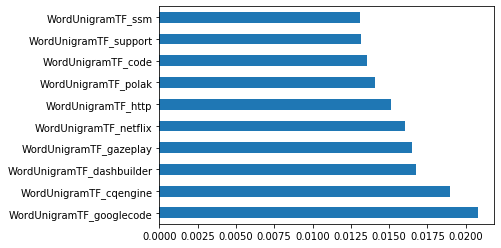

In [40]:
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')  # Top 10 features
plt.show()